# Introduction

Using data about animals of various classes such as (Mammals, Reptiles, Amphibians etc.,) we perform hypothesis testing to check if certain species have more number of animals that require protection.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency



In [98]:
species = pd.read_csv("species_info.csv")
print(species.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  


In [4]:
species.category.unique()

array(['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant',
       'Nonvascular Plant'], dtype=object)

How many different species are in the `species` DataFrame?

In [5]:
unique_no_species = species.scientific_name.nunique()
print("There are {} unique species of animals".format(unique_no_species))

There are 5541 unique species of animals


What are the different values of `category` in `species`?

In [7]:
different_categories = species.category.unique()
print("Different categories of animals are: ")
for category in different_categories:
    print(category)

Different categories of animals are: 
Mammal
Bird
Reptile
Amphibian
Fish
Vascular Plant
Nonvascular Plant


What are the different values of `conservation_status`?

In [8]:
different_statuses = species.conservation_status.unique()
print("Different conservation statuses:")
for status in different_statuses:
    print(status)


Different conservation statuses:
nan
Species of Concern
Endangered
Threatened
In Recovery


## Conservation Status frequency

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currnetly neither in danger of extinction throughout all or a significant portion of its range


In [99]:
species.conservation_status.fillna("No Intervention", inplace=True)
conservationCounts = species.groupby('conservation_status').scientific_name.count()
print("Number of animals in each conservation status:")
print(conservationCounts)

Number of animals in each conservation status:
conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
Name: scientific_name, dtype: int64


From the above table, we can see that 
<ul>
    <li>5633 species do not need any kind of protection.</li>
    <li>16 species are endangered.</li>
    <li>4 species are in recovery.</li>
    <li>161 species are in the danger zone.</li>
    <li>10 species are threatened.</li>
</ul>

In [32]:
protection_counts = species.groupby('conservation_status').scientific_name.count().reset_index().sort_values('scientific_name')

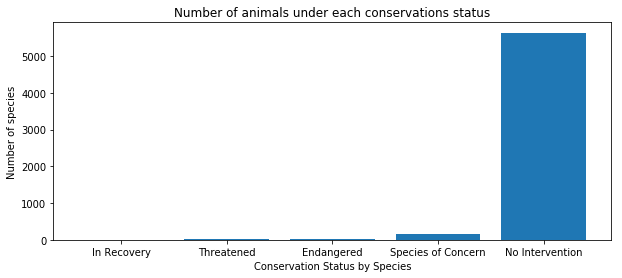

In [33]:
plt.figure(figsize=(10,4))
ax = plt.subplot()
plt.bar(range(len(protection_counts)), protection_counts['scientific_name'])
ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts['conservation_status'])
plt.xlabel('Conservation Status by Species')
plt.ylabel('Number of species')
plt.title('Number of animals under each conservations status')
plt.savefig("conservationCounts.png")
plt.show()

# Are certain types of species more likely to be endangered?

Let's create a new column in `species` called `is_protected`, which is `True` if `conservation_status` is not equal to `No Intervention`, and `False` otherwise.

In [14]:
species['is_protected'] = species.conservation_status.apply(lambda status: False if status == "No Intervention" else True)
print(species.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  \
0                           Gapper's Red-Backed Vole     No Intervention   
1                              American Bison, Bison     No Intervention   
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...     No Intervention   
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)     No Intervention   
4                                      Wapiti Or Elk     No Intervention   

   is_protected  
0         False  
1         False  
2         False  
3         False  
4         False  


In [49]:
category_counts = species.groupby(['category', 'is_protected']).scientific_name.count().reset_index()
category_pivot = category_counts.pivot(columns='is_protected',index="category", values="scientific_name")
category_pivot.rename(columns={False:"protection_not_needed", True:"protection_needed"}, inplace=True)
category_pivot['percent_protection_needed'] = category_pivot.apply(lambda row: \
                                                         float((row['protection_needed'])/(row['protection_needed']+row['protection_not_needed'])*100),axis=1)

Examine `category_pivot`.

/Users/command/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


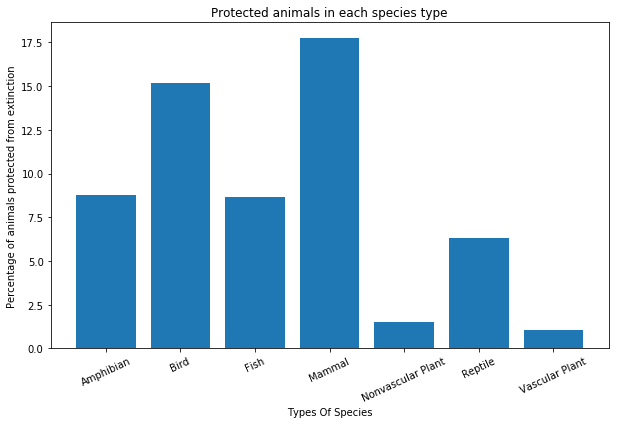

In [51]:
plt.figure(figsize=(10,6))
plt.bar(range(len(category_pivot)), category_pivot['percent_protection_needed'])
ax = plt.subplot()
labels=["Amphibian","Bird", "Fish", "Mammal", "Nonvascular Plant", "Reptile", "Vascular Plant"]
ax.set_xticks(range(len(category_pivot)))
ax.set_xticklabels(labels, rotation=25)
plt.xlabel("Types Of Species")
plt.ylabel("Percentage of animals protected from extinction")
plt.title("Protected animals in each species type")
plt.savefig("protectedSpecies.png")

## Chi Square Test to test significance in protection requirements among animal classes

A large portion of mammals seem to need protection from the bar chart. A chi-square test can be performed to see if the differences in portions of animals needing protection in each category is significant.

In [91]:
categories = list(category_pivot.index.values)
combinations = []
chi_square_test = []
for categoryOne in categories:
    for categoryTwo in categories:
        comb = [categoryOne, categoryTwo]
        comb_inv = [categoryTwo, categoryOne]
        if (categoryOne != categoryTwo) and (comb not in combinations) and (comb_inv not in combinations):
            combinations.append(comb)
            combinations.append(comb_inv)
            test_details = []
            contingency_table = []
            cat_one_details = []
            cat_two_details = []
            cat_one_details.append(category_pivot.loc[categoryOne,"protection_not_needed"])
            cat_one_details.append(category_pivot.loc[categoryOne,"protection_needed"])
            contingency_table.append(cat_one_details)
            cat_two_details.append(category_pivot.loc[categoryTwo,"protection_not_needed"])
            cat_two_details.append(category_pivot.loc[categoryTwo,"protection_needed"])
            contingency_table.append(cat_two_details)
            test_details.append(categoryOne)
            test_details.append(categoryTwo)
            _, pvalue, _, _ = chi2_contingency(contingency_table)
            test_details.append(pvalue)
            chi_square_test.append(test_details)

# print(chi_square_test)
chi_test_results = pd.DataFrame(chi_square_test, columns=["category_one", "category_two", "Pvalue"])
print(chi_test_results)

         category_one       category_two        Pvalue
0           Amphibian               Bird  1.758278e-01
1           Amphibian               Fish  8.171118e-01
2           Amphibian             Mammal  8.416929e-02
3           Amphibian  Nonvascular Plant  1.965877e-03
4           Amphibian            Reptile  7.813397e-01
5           Amphibian     Vascular Plant  4.808330e-09
6                Bird               Fish  7.897199e-02
7                Bird             Mammal  4.459017e-01
8                Bird  Nonvascular Plant  1.355140e-10
9                Bird            Reptile  5.303197e-02
10               Bird     Vascular Plant  9.296288e-84
11               Fish             Mammal  3.114526e-02
12               Fish  Nonvascular Plant  5.357944e-04
13               Fish            Reptile  7.335180e-01
14               Fish     Vascular Plant  3.930722e-13
15             Mammal  Nonvascular Plant  1.681893e-11
16             Mammal            Reptile  2.338465e-02
17        

We calculated p value for all combinations of animal classes to determine which classes are significantly different in terms of requiring protection. The categories that are significantly different are

In [118]:
significant_chi = chi_test_results.query("Pvalue <= 0.05")
sig_chi_pivot = significant_chi.pivot(columns="category_one", index="category_two", values="Pvalue")
print(sig_chi_pivot)

category_one          Amphibian          Bird          Fish        Mammal  \
category_two                                                                
Mammal                      NaN           NaN  3.114526e-02           NaN   
Nonvascular Plant  1.965877e-03  1.355140e-10  5.357944e-04  1.681893e-11   
Reptile                     NaN           NaN           NaN  2.338465e-02   
Vascular Plant     4.808330e-09  9.296288e-84  3.930722e-13  1.734911e-70   

category_one       Nonvascular Plant   Reptile  
category_two                                    
Mammal                           NaN       NaN  
Nonvascular Plant                NaN       NaN  
Reptile                     0.035719       NaN  
Vascular Plant                   NaN  0.000098  


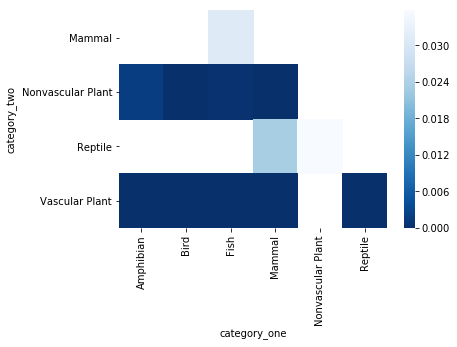

In [122]:
import seaborn as sb
sb.heatmap(sig_chi_pivot, cmap="Blues_r")

We could see that protection required by mammals is significantly higher than fishes, reptiles, vascular plants and non vascular plants.

# Step 5

In [94]:
observations = pd.read_csv('observations.csv')
print(observations.head())

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85


Some scientists are studying the number of sheep sightings at different national parks.  There are several different scientific names for different types of sheep.  We'd like to know which rows of `species` are referring to sheep.  Notice that the following code will tell us whether or not a word occurs in a string:

In [95]:
species['is_sheep'] = species.common_names.apply(lambda name: 'Sheep' in name)
sheep_species = species[(species.is_sheep == True) & (species.category == "Mammal")]
sheep_observations = pd.merge(sheep_species, observations)


In [96]:
print(sheep_observations.head(5))

  category  scientific_name  \
0   Mammal       Ovis aries   
1   Mammal       Ovis aries   
2   Mammal       Ovis aries   
3   Mammal       Ovis aries   
4   Mammal  Ovis canadensis   

                                        common_names conservation_status  \
0  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)     No Intervention   
1  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)     No Intervention   
2  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)     No Intervention   
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)     No Intervention   
4                       Bighorn Sheep, Bighorn Sheep  Species of Concern   

   is_protected  is_sheep                            park_name  observations  
0         False      True               Yosemite National Park           126  
1         False      True  Great Smoky Mountains National Park            76  
2         False      True                  Bryce National Park           119  
3         False      True            Yel

## Total Number of sheep observations made at each park

This is the total number of sheep observed in each park over the past 7 days.

In [114]:
obs_by_park = sheep_observations.groupby('park_name').observations.sum().reset_index()
print(obs_by_park)

                             park_name  observations
0                  Bryce National Park           250
1  Great Smoky Mountains National Park           149
2            Yellowstone National Park           507
3               Yosemite National Park           282


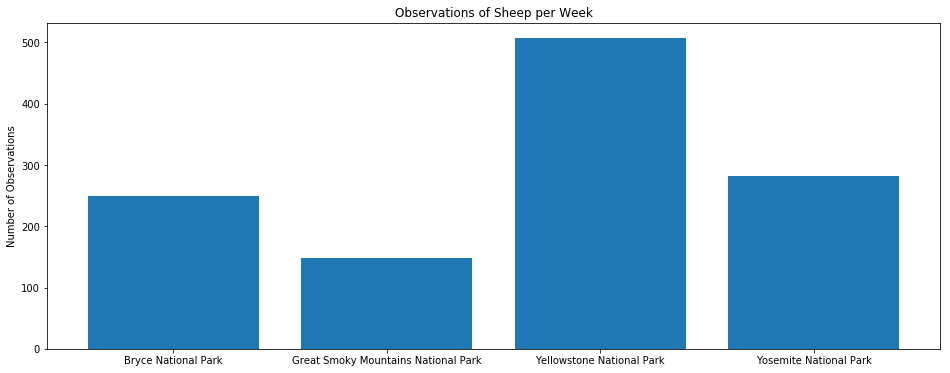

In [115]:
plt.figure(figsize=(16, 6))
ax = plt.subplot()
plt.bar(range(len(obs_by_park)), obs_by_park['observations'])
ax.set_xticks(range(len(obs_by_park)))
ax.set_xticklabels(obs_by_park.park_name)
plt.ylabel("Number of Observations")
plt.title("Observations of Sheep per Week")
plt.savefig("sheepInParks.png")
plt.show()